This notebook contains several classification approaches to classify 10-K excerpts. The dataset is provided by SASB. 5 text preprocessing methods were used:
- CountVectorizer
- TF-IDF Vectorizer
- TF-IDF Vectorizer with bigrams
- Word Embeddings (pre-trained using proxy statements)
- Word Embeddings (pre-trained using 10-K's) These were downloaded from: https://github.com/ssehrawat/10K-word-embeddings

Logistic Regression is the supervised learning algorithm used in thie notebook. The objective is to maximize the recall of the classifier. This was done through thresholding.

```tqdm``` is used to observe the progress bar when a cell is running.

In [2]:
from tqdm import tqdm
tqdm.pandas()

Import necessary libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

#NLP Text Preprocessing
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Logistic Regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score

The DataFrame is loaded and assigned the variable ```json```.

In [4]:
json = pd.read_json("di_hc_rel_train.json")
json

,excerpt_id,excerpt,company_ticker,disclosure_topic_id,industry_id,source_document,relevance_assessment,quality_assessment
0,2017-AAL-TR-AL-310a-147641,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure
1,2017-AAL-TR-AL-310a-147711,Earnings per share:\nShares used for computati...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure
2,2017-AAL-TR-AL-310a-148045,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure
3,2017-AAL-TR-AL-310a-2483765,Approximate number of active full-time equival...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure
4,2017-AAL-TR-AL-310a-2484043,Employee bonus expense included costs related ...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure
...,...,...,...,...,...,...,...,...
20621,SD_2017_M_PCG_IF-EU-320a,Order Instituting an Investigation into the Ut...,PCG,IF-EU-320a,IF-EU,None,Relevant,Company Tailored Narrative
20622,SD_2017_M_SEAS_SV-LF-320a,\n\nFeaturing animals at our theme parks invol...,SEAS,SV-LF-320a,SV-LF,None,Relevant,Metrics
20623,SD_2017_M_STO_EM-EP-320a,"2.12 SAFETY, SECURITY AND SUSTAINABILITY\n\nSa...",STO,EM-EP-320a,EM-EP,None,Relevant,Metrics
20624,SD_2017_M_WMT_CG-MR-330a,We are subject to certain legal proceedings th...,WMT,CG-MR-330a,CG-MR,None,Relevant,Company Tailored Narrative


This cell shows how many excerpts are labeled 'Relevant' and 'No Disclosure'.

In [5]:
json['relevance_assessment'].value_counts()

No Disclosure    11463
Relevant          9163
Name: relevance_assessment, dtype: int64

The dataframe  ```disclosure_topic.csv``` is loaded.

In [6]:
# Import csv lookup
toplabel = pd.read_csv("disclosure_topic.csv")
toplabel.columns = map(str.lower, toplabel.columns)
toplabel.head()

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension
0,CG-AA-250a,Management of Chemicals in Products,CG-AA,NaN
1,CG-AA-430a,Environmental Impacts in the Supply Chain,CG-AA,NaN
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN
3,CG-AA-440a,Raw Materials Sourcing,CG-AA,NaN
4,CG-AM-250a,Product Safety,CG-AM,NaN


Subset the dataframe to show only those rows that are related to labor.

In [7]:
# How many are related to labor? Subset Dataframe
labor = toplabel[toplabel["disclosure_topic_name"].str.contains("labor", case = False) ]
labor

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN
21,CG-MR-310a,Labor Practices,CG-MR,NaN
25,CG-TS-430a,Labor Conditions in the Supply Chain,CG-TS,NaN
41,EM-CO-310a,Labor Relations,EM-CO,NaN
75,EM-MM-310a,Labor Relations,EM-MM,NaN
117,FB-FR-310a,Labor Practices,FB-FR,NaN
150,FB-RN-310a,Labor Practices,FB-RN,NaN
258,IF-WM-310a,Labor Practices,IF-WM,NaN
350,SV-HL-310a,Labor Practices,SV-HL,NaN
363,TC-ES-310a,Labor Practices,TC-ES,NaN


A column ```disclosure_islabor``` is added. It is True if the disclosure is related to labor.

In [8]:
# Create new label that flags labor only
toplabel["disclosure_islabor"] = toplabel["disclosure_topic_name"].str.contains("labor", case = False)
toplabel.head()

,disclosure_topic_id,disclosure_topic_name,industry_id,sustainability_dimension,disclosure_islabor
0,CG-AA-250a,Management of Chemicals in Products,CG-AA,NaN,False
1,CG-AA-430a,Environmental Impacts in the Supply Chain,CG-AA,NaN,False
2,CG-AA-430b,Labor Conditions in the Supply Chain,CG-AA,NaN,True
3,CG-AA-440a,Raw Materials Sourcing,CG-AA,NaN,False
4,CG-AM-250a,Product Safety,CG-AM,NaN,False


In [9]:
toplabel['disclosure_islabor'].value_counts()

False    429
True      15
Name: disclosure_islabor, dtype: int64

In [10]:
# Check excerpts more closely
json["excerpt"].head()

# Are there any duplicates in text, in excerpt_id?
json.shape
json.drop_duplicates("excerpt").shape
json.drop_duplicates("excerpt_id").shape
# So, there are duplicates in text but not in excerpt_id

# What proportion are quality_assessment, relevance_assessment categories?
#json["relevance_assessment"].groupby("relevance_assessment").agg("count")

# Are there any duplicates in text, in excerpt_id?

(20626, 8)

In [11]:
# Merge, take tally of all disclosure topic occurrences
json = pd.merge(json, right = toplabel, 
               on = "disclosure_topic_id")
json.head()

# # Figure out how many related to any disclosure
# json["is_disclosure"] = json["relevance_assessment"]
# # Figure out how many related to labor

,excerpt_id,excerpt,company_ticker,disclosure_topic_id,industry_id_x,source_document,relevance_assessment,quality_assessment,disclosure_topic_name,industry_id_y,sustainability_dimension,disclosure_islabor
0,2017-AAL-TR-AL-310a-147641,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True
1,2017-AAL-TR-AL-310a-147711,Earnings per share:\nShares used for computati...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True
2,2017-AAL-TR-AL-310a-148045,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True
3,2017-AAL-TR-AL-310a-2483765,Approximate number of active full-time equival...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True
4,2017-AAL-TR-AL-310a-2484043,Employee bonus expense included costs related ...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True


In [12]:
#subset dataframe: relevance assessment is Relevant and disclosure is True

json[(json['relevance_assessment'] == 'Relevant') & (json['disclosure_islabor']==True)]

,excerpt_id,excerpt,company_ticker,disclosure_topic_id,industry_id_x,source_document,relevance_assessment,quality_assessment,disclosure_topic_name,industry_id_y,sustainability_dimension,disclosure_islabor
6,2017-AAL-TR-AL-310a-2484240,"Salaries, wages and benefits increased 8.5% pr...",AAL,TR-AL-310a,TR-AL,,Relevant,Metrics,Labor Practices,TR-AL,NaN,True
7,2017-AAL-TR-AL-310a-2484280,"Salaries, wages and benefits increased 14.4% p...",AAL,TR-AL-310a,TR-AL,,Relevant,Metrics,Labor Practices,TR-AL,NaN,True
12,2017-AAL-TR-AL-310a-2485047,Labor contract expenses primarily included one...,AAL,TR-AL-310a,TR-AL,,Relevant,Company Tailored Narrative,Labor Practices,TR-AL,NaN,True
13,2017-AAL-TR-AL-310a-2485164,American sponsors defined benefit and defined ...,AAL,TR-AL-310a,TR-AL,,Relevant,Metrics,Labor Practices,TR-AL,NaN,True
14,2017-AAL-TR-AL-310a-2485169,"During 2017, American contributed $286 million...",AAL,TR-AL-310a,TR-AL,,Relevant,Metrics,Labor Practices,TR-AL,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19760,A2_01-01-2019_SANM_10-K_TC-ES-320a_6M,We have a range of corporate programs that aim...,SANM,TC-ES-320a,TC-ES,10-K,Relevant,Company Tailored Narrative,Labor Conditions,TC-ES,NaN,True
19761,A2_01-01-2019_SANM_10-K_TC-ES-320a_8,If we manufacture or design defective products...,SANM,TC-ES-320a,TC-ES,10-K,Relevant,Boilerplate,Labor Conditions,TC-ES,NaN,True
19762,A2_01-01-2019_SGMA_10-K_TC-ES-320a_3,The Company’s operations are subject to certai...,SGMA,TC-ES-320a,TC-ES,10-K,Relevant,Boilerplate,Labor Conditions,TC-ES,NaN,True
19764,A2_2019_PLXS_TC-ES-320a_973119,Plexus is committed to social responsibility t...,PLXS,TC-ES-320a,TC-ES,10-K,Relevant,Company Tailored Narrative,Labor Conditions,TC-ES,NaN,True


In [13]:
# add label: target is 1
json['relevance_islabor'] = np.where((json['relevance_assessment']=='Relevant')&(json['disclosure_islabor']==True), 1, 0)

In [14]:
json['relevance_islabor'].value_counts()

0    18464
1     2162
Name: relevance_islabor, dtype: int64

The graph below shows that the target variable ```relevance_islabor``` is imbalanced.

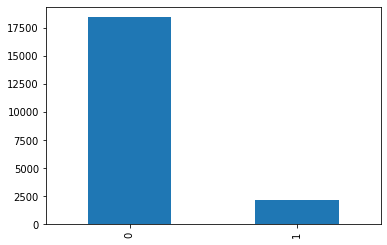

In [15]:
json['relevance_islabor'].value_counts().plot(kind='bar')

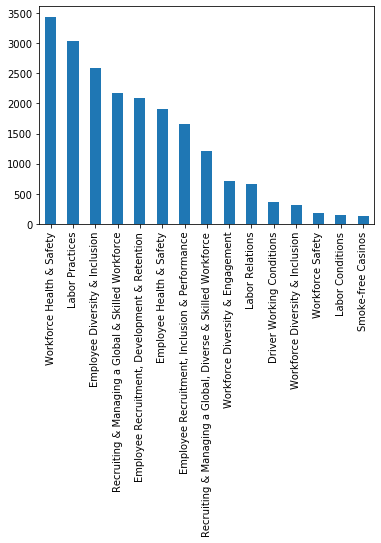

In [16]:
json['disclosure_topic_name'].value_counts().plot(kind='bar')

### Text Pre-processing

Text must be preprocessed into numerical form before performing classification.

In [18]:
def stem_tokenizer(text):
    porter_stemmer=PorterStemmer()
    return [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]

def my_tokenizer(text):
    porter_stemmer = PorterStemmer()
    punctuation=list(string.punctuation)
    #added_stopwords (DOMAIN SPECIFIC): director, compani, share, stock
    stop0=" ".join(stopwords.words("english")+punctuation) #add more stopwords?
    stop_words=set(stem_tokenizer(stop0))
    stem_list=stem_tokenizer(text)
    used_list=[token for token in stem_list if token not in stop_words]
    return used_list

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Excerpt {:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [19]:
#Array of Excerpts to be pre-processed
text_train = np.array(json['excerpt'])

### a. Count Vectorizer

In [18]:
count_vect = CountVectorizer(tokenizer= my_tokenizer)
X_count = count_vect.fit_transform(text_train)
X_count = normalize(X_count)
count_features = count_vect.get_feature_names()
wm2df(X_count, count_features)

,'','100,'1999,'2004,'2009,'2012,'2013,'2014,'2015,'2016,...,€6.74,€633.0,€7.2,€7.3,€7.5,€738.5,€8.35,€9.3,€9.7,€nil
Excerpt 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Excerpt 20621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The cell below sets the y variable.

In [33]:
#Target Variable
y = np.array(json['relevance_islabor'])

### Logistic Regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_count, y, random_state=42)

In [44]:
scores = cross_val_score(LogisticRegression(class_weight = 'balanced', max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross_validation accuracy: {: 2f}".format(np.mean(scores)))


#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight = 'balanced', max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


print("Test score: {:2f}".format(grid.score(X_test, y_test)))

Mean cross_validation accuracy:  0.927662
Best cross-validation score: 0.941496
Best parameters:  {'C': 10}
Test score: 0.944154


### Dataframe of Actual vs Predicted Values

In [41]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000).fit(X_train, y_train)

y_pred = logreg.predict(X_test)

df_logreg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_logreg['Actual'].value_counts())
print(df_logreg['Predicted'].value_counts())

0    4647
1     510
Name: Actual, dtype: int64
0    4387
1     770
Name: Predicted, dtype: int64


In [28]:
#predict probabilities
y_proba = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_proba = y_proba[:, 1]

### Evaluation Metrics

In [42]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[4343  304]
 [  44  466]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4647
           1       0.61      0.91      0.73       510

    accuracy                           0.93      5157
   macro avg       0.80      0.92      0.84      5157
weighted avg       0.95      0.93      0.94      5157



### Precision Recall curve

In [29]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, logreg.decision_function(X_test))
print("Average Precision Recall Score:", average_precision)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1])
auc_score = auc(recall, precision)

Average Precision Recall Score: 0.8288164271542808


AUC: 0.829


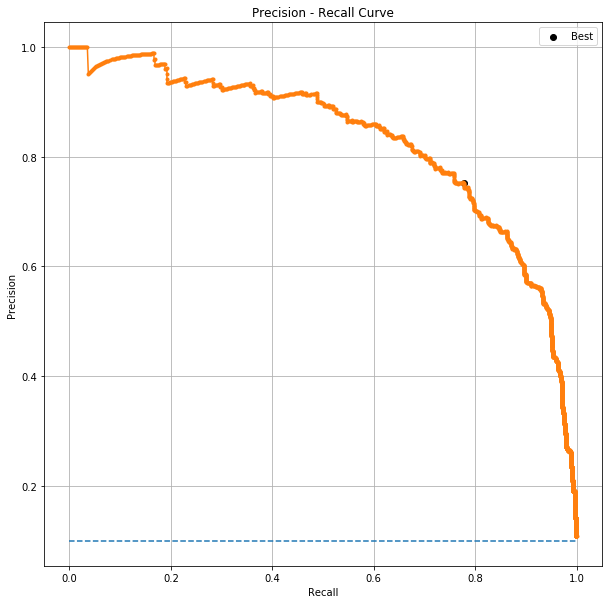

In [34]:
print('AUC: %.3f' % auc_score)
negative = len(y_test[y_test == 1])/ len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0,1], [negative, negative], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Precision - Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### Lowering Threshold

In [32]:
from numpy import argmax
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.289554, F-Score=0.765


Raising our classification threshold will cause the number of true positives to decrease or stay the same and will cause the number of false negatives to increase or stay the same. Thus, recall will either stay constant or decrease.
- Why use class_weight= "balanced"
- with class_weight="balanced" you capture more true events (higher TRUE recall) but also you are more likely to get false alerts (lower TRUE precision) as a result, the total % TRUE might be higher than actual because of all the false positives

### Visualize Coefficients

In [26]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 10))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


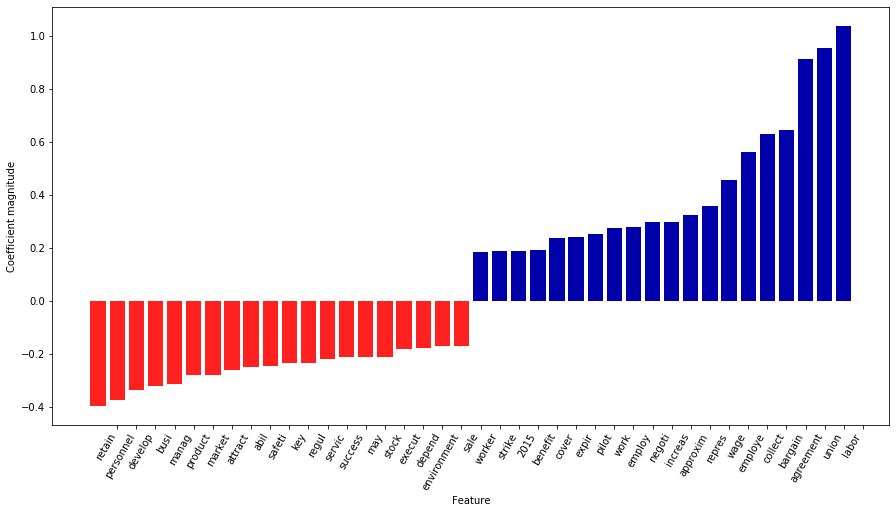

In [27]:
coefs = LogisticRegression(C=0.01).fit(X_train, y_train).coef_

visualize_coefficients(coefs, count_features, n_top_features=20)

### b. Tf-idf Vectorizer

In [43]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer)
X_tfidf = tfidf_vectorizer.fit_transform(text_train)
X_tfidf = normalize(X_tfidf)
tfidf_features = tfidf_vectorizer.get_feature_names()
wm2df(X_tfidf, tfidf_features)

,'','100,'1999,'2004,'2009,'2012,'2013,'2014,'2015,'2016,...,€6.74,€633.0,€7.2,€7.3,€7.5,€738.5,€8.35,€9.3,€9.7,€nil
Excerpt 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Excerpt 20621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42)
scores = cross_val_score(LogisticRegression(class_weight = 'balanced', max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross_validation accuracy: {: 2f}".format(np.mean(scores)))


#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight = 'balanced', max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

print("Test score: {:2f}".format(grid.score(X_test, y_test)))

Mean cross_validation accuracy:  0.944922
Best cross-validation score: 0.955588
Best parameters:  {'C': 10}
Test score: 0.959666


### Actual vs Predicted Values

In [30]:
logreg_2 = LogisticRegression(class_weight = 'balanced', max_iter = 1000).fit(X_train, y_train)

y_pred = logreg_2.predict(X_test)

df_logreg_2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_logreg_2['Actual'].value_counts())
print(df_logreg_2['Predicted'].value_counts())

0    4647
1     510
Name: Actual, dtype: int64
0    4789
1     368
Name: Predicted, dtype: int64


### Evaluation Metrics

In [31]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[4596   51]
 [ 193  317]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4647
           1       0.86      0.62      0.72       510

    accuracy                           0.95      5157
   macro avg       0.91      0.81      0.85      5157
weighted avg       0.95      0.95      0.95      5157



Correctly identifies 62% of relevant and labor disclosures

### Precision Recall Curve

In [32]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, logreg_2.decision_function(X_test))
print("Average Precision Recall Score:", average_precision)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, logreg_2.predict_proba(X_test)[:,1])
auc_score = auc(recall, precision)

Average Precision Recall Score: 0.8366047848524957


AUC: 0.836


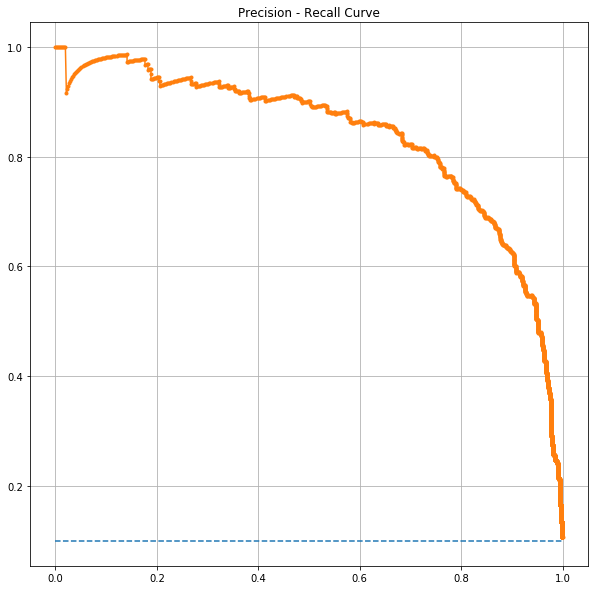

In [33]:
print('AUC: %.3f' % auc_score)
negative = len(y_test[y_test == 1])/ len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0,1], [negative, negative], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Precision - Recall Curve')
plt.grid()
plt.show()

### Visualize coefficients

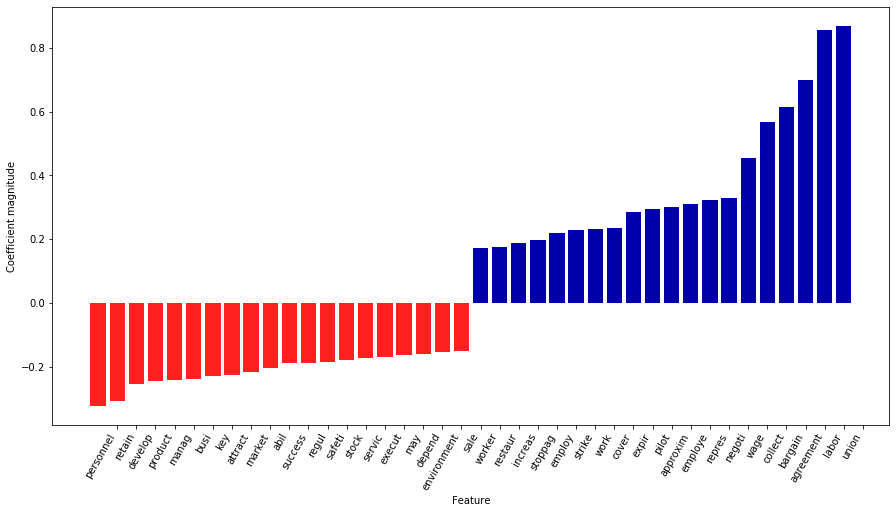

In [34]:
tfidf_coefs = LogisticRegression(C=0.01).fit(X_train, y_train).coef_

visualize_coefficients(tfidf_coefs, tfidf_features, n_top_features=20)

### c. Tf-idf Vectorizer with bigrams

In [51]:
tfidf_vectorizer_2 = TfidfVectorizer(ngram_range=(2,2), tokenizer=my_tokenizer)
X_tfidf_2 = tfidf_vectorizer_2.fit_transform(text_train)
X_tfidf_2 = normalize(X_tfidf_2)
tfidf_features_2 = tfidf_vectorizer_2.get_feature_names()
wm2df(X_tfidf_2, tfidf_features_2)

,'' '','' -incid,'' .__these,'' 19,'' 2006,'' 2011,'' 2013,'' 2014-09,'' 2015,'' 2017,...,€633.0 million,€7.2 million,€7.3 million,€7.5 2015,€7.5 million,€738.5 million,€8.35 exercis,€9.3 million,€9.7 million,€nil million
Excerpt 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Excerpt 20621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Excerpt 20624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_2, y, random_state=42)
scores = cross_val_score(LogisticRegression(max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross_validation accuracy: {: 2f}".format(np.mean(scores)))


#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

print("Test score: {:2f}".format(grid.score(X_test, y_test)))

Mean cross_validation accuracy:  0.918611
Best cross-validation score: 0.941625
Best parameters:  {'C': 10}
Test score: 0.954431


### Dataframe of Actual vs. Predicted Values

In [53]:
logreg_3 = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

y_pred = logreg_3.predict(X_test)

df_logreg_3 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_logreg_3['Actual'].value_counts())
print(df_logreg_3['Predicted'].value_counts())

0    4647
1     510
Name: Actual, dtype: int64
0    4961
1     196
Name: Predicted, dtype: int64


### Evaluation Metrics

In [54]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[4633   14]
 [ 328  182]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4647
           1       0.93      0.36      0.52       510

    accuracy                           0.93      5157
   macro avg       0.93      0.68      0.74      5157
weighted avg       0.93      0.93      0.92      5157



### Precision Recall Curve

In [56]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, logreg_3.decision_function(X_test))
print("Average Precision Recall Score:", average_precision)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, logreg_3.predict_proba(X_test)[:,1])
auc_score = auc(recall, precision)

Average Precision Recall Score: 0.8292063990460184


AUC: 0.829


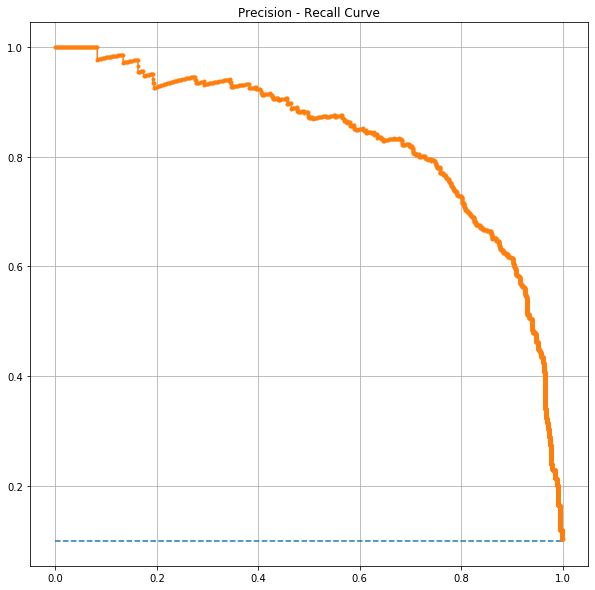

In [57]:
print('AUC: %.3f' % auc_score)
negative = len(y_test[y_test == 1])/ len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0,1], [negative, negative], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Precision - Recall Curve')
plt.grid()
plt.show()

### Visualize Coefficients

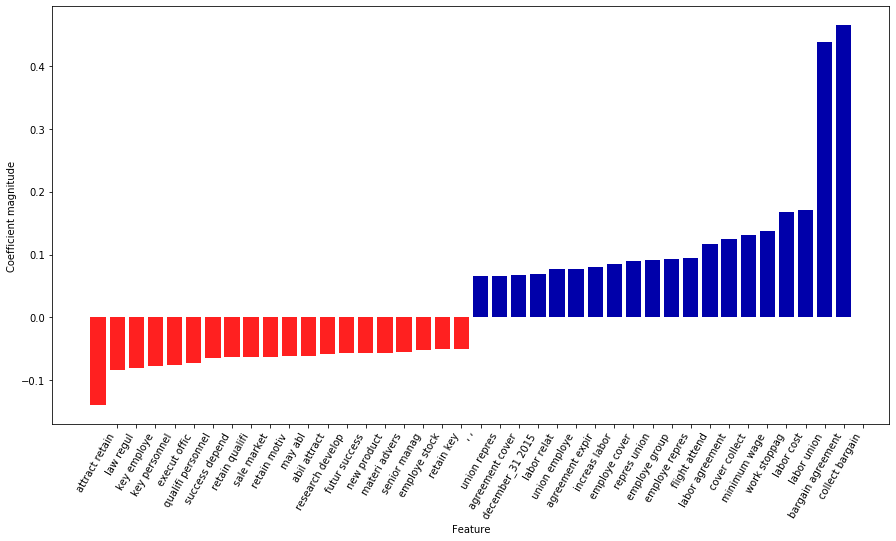

In [58]:
tfidf_coefs_2 = LogisticRegression(C=0.01).fit(X_train, y_train).coef_

visualize_coefficients(tfidf_coefs_2, tfidf_features_2, n_top_features=20)

### d. Word Embeddings Word2vec

- Goal: Use the pre-trained word embeddings from the proxy statements to classify

#### Make necessary processing for the word embeddings

In [20]:
def preprocess(paragraph):
    text = re.sub(r'\[[0-9]*\]',' ',paragraph)
    text = re.sub(r'\s+',' ',text)
    text = text.lower()
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

import string

def token_words(sentence_list): #sentence_list is a row in the datframe
    punctuation=nltk.word_tokenize(string.punctuation)
    paragraph = nltk.word_tokenize(sentence_list)
    
    return [token for token in paragraph if token not in punctuation]


json['trial'] = json.progress_apply(lambda x: preprocess(x['excerpt']), axis = 1)
json['paragraph'] = json.progress_apply(lambda x: token_words(x['trial']), axis = 1)

100%|██████████| 20626/20626 [00:19<00:00, 1053.94it/s]


In [21]:
json.head(5)

,excerpt_id,excerpt,company_ticker,disclosure_topic_id,industry_id_x,source_document,relevance_assessment,quality_assessment,disclosure_topic_name,industry_id_y,sustainability_dimension,disclosure_islabor,relevance_islabor,trial,paragraph
0,2017-AAL-TR-AL-310a-147641,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True,0,reclassifications out of aoci for the years en...,"[reclassifications, out, of, aoci, for, the, y..."
1,2017-AAL-TR-AL-310a-147711,Earnings per share:\nShares used for computati...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True,0,earnings per share: shares used for computatio...,"[earnings, per, share, shares, used, for, comp..."
2,2017-AAL-TR-AL-310a-148045,Reclassifications out of AOCI for the years en...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True,0,reclassifications out of aoci for the years en...,"[reclassifications, out, of, aoci, for, the, y..."
3,2017-AAL-TR-AL-310a-2483765,Approximate number of active full-time equival...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True,0,approximate number of active full-time equival...,"[approximate, number, of, active, full-time, e..."
4,2017-AAL-TR-AL-310a-2484043,Employee bonus expense included costs related ...,AAL,TR-AL-310a,TR-AL,,No Disclosure,No Disclosure,Labor Practices,TR-AL,NaN,True,0,employee bonus expense included costs related ...,"[employee, bonus, expense, included, costs, re..."


Load the pre-trained word embeddings model.

In [25]:
import gensim

model = gensim.models.Word2Vec.load("word2vec_proxy_docs.model")

In [21]:
def paragraph_vectorizer(paragraph, model):
    paragraph_vec =[]
    numw = 0
    for w in paragraph:
        try:
            if numw == 0:
                paragraph_vec = model.wv[w]
            else:
                paragraph_vec = np.add(paragraph_vec, model.wv[w])
            numw+=1
        except:
            pass
    if len(paragraph_vec) == 150:
     
        return np.asarray(paragraph_vec) / numw
    else:
        return None

In [22]:
#CREATE THE MATRIX
paragraphs = json.paragraph.tolist()
X=[]
for idx, paragraph in tqdm(enumerate(paragraphs)):
    result=paragraph_vectorizer(paragraph, model)
    if result is None:
        print('No Vector for Paragraph: {a}'.format(a=idx))
    else:  
        X.append(paragraph_vectorizer(paragraph, model)) 

20626it [00:08, 2384.78it/s]


### Logistic Regression

In [34]:
X = (np.stack(X, axis = 0)) #(20626, 150)
y = np.array(json['relevance_islabor'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scores = cross_val_score(LogisticRegression(max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross_validation accuracy: {: 2f}".format(np.mean(scores)))


#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

print("Test score: {:2f}".format(grid.score(X_test, y_test)))

Mean cross_validation accuracy:  0.922555
Best cross-validation score: 0.928050
Best parameters:  {'C': 10}
Test score: 0.934070


### Actual vs. Predicted Value

In [35]:
logreg_4 = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

y_pred = logreg_4.predict(X_test)

df_logreg_4 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_logreg_4['Actual'].value_counts())
print(df_logreg_4['Predicted'].value_counts())

0    4647
1     510
Name: Actual, dtype: int64
0    4852
1     305
Name: Predicted, dtype: int64


### Evaluation Metrics

In [36]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[4568   79]
 [ 284  226]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4647
           1       0.74      0.44      0.55       510

    accuracy                           0.93      5157
   macro avg       0.84      0.71      0.76      5157
weighted avg       0.92      0.93      0.92      5157



### Precision-Recall Curve

In [38]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, logreg_4.decision_function(X_test))
print("Average Precision Recall Score:", average_precision)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, logreg_4.predict_proba(X_test)[:,1])
auc_score = auc(recall, precision)

Average Precision Recall Score: 0.6550665690236841


AUC: 0.653


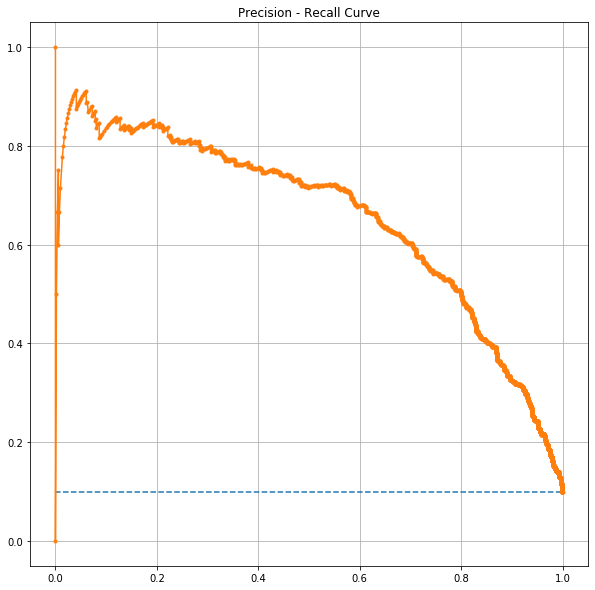

In [39]:
print('AUC: %.3f' % auc_score)
negative = len(y_test[y_test == 1])/ len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0,1], [negative, negative], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Precision - Recall Curve')
plt.grid()
plt.show()

### e. 10-K Word Embeddings: Pre-Trained


The pre-trained word embeddings on 10-K's were downloaded: ```10k_word_embeddings.tar``` and ```vocab_to_int.tar```.

In [17]:
import torch

In [18]:
embed = torch.load('10k_word_embeddings.tar') #the vectors
vocab_to_int = torch.load('vocab_to_int.tar') #the words

In [19]:
def paragraph_vectorizer(paragraph, model):
    paragraph_vec =[]
    numw = 0
    for w in paragraph:
        try:
            if numw == 0:
                paragraph_vec = model[vocab_to_int[w]]
            else:
                paragraph_vec = np.add(paragraph_vec, model[vocab_to_int[w]])
            numw+=1
        except:
            pass
    if len(paragraph_vec) == 300:
     
        return np.asarray(paragraph_vec) / numw
    else:
        return None

In [22]:
X=[]
paragraphs = json.paragraph.tolist()

for idx, paragraph in tqdm(enumerate(paragraphs)):
    result=paragraph_vectorizer(paragraph, embed)
    if result is None:
        print('No Vector for Paragraph: {a}'.format(a=idx))
    else:  
        X.append(result) 


20626it [00:02, 8250.29it/s]


### Logistic Regression

In [23]:
X = (np.stack(X, axis = 0)) #(20626, 150)
y = np.array(json['relevance_islabor'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scores = cross_val_score(LogisticRegression(max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross_validation accuracy: {: 2f}".format(np.mean(scores)))


#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

print("Test score: {:2f}".format(grid.score(X_test, y_test)))

Mean cross_validation accuracy:  0.933544
Best cross-validation score: 0.940203
Best parameters:  {'C': 10}
Test score: 0.944541


### Actual vs. Predicted Values

- Applying the new threshold
- The threshold for Logistic Regression is at 0.5 as a default. The cell below is used to lower the threshold. This is done in order to increase recall and decrease precision. In this case, the threshold was lowered to 0.10.

In [24]:
logreg_5 = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

y_pred = logreg_5.predict(X_test)

df_logreg_5 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_logreg_5['Actual'].value_counts())
print(df_logreg_5['Predicted'].value_counts())


#New Threshold
y_pred_new_threshold = (logreg_5.predict_proba(X_test)[:,1]>=0.10).astype(int)


df_logreg_5['Lower_Threshold'] = y_pred_new_threshold
print(df_logreg_5['Lower_Threshold'].value_counts())


0    4647
1     510
Name: Actual, dtype: int64
0    4793
1     364
Name: Predicted, dtype: int64
0    4114
1    1043
Name: Lower_Threshold, dtype: int64


### Evaluation Metrics With the Original Threshold
- The recall is 57%.

In [29]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[4573   74]
 [ 220  290]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4647
           1       0.80      0.57      0.66       510

    accuracy                           0.94      5157
   macro avg       0.88      0.78      0.82      5157
weighted avg       0.94      0.94      0.94      5157



### Evaluation Metrics With A Lowered Threshold
- The recall is 92% when using the lower threshold.

In [63]:
#calculate recall
from sklearn.metrics import recall_score

recall_score(y_test, y_pred_new_threshold)


#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_new_threshold)
print("Confusion Matrix")
print(confusion_matrix)
print()

#Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, y_pred_new_threshold))

Confusion Matrix
[[4071  576]
 [  43  467]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      4647
           1       0.45      0.92      0.60       510

    accuracy                           0.88      5157
   macro avg       0.72      0.90      0.77      5157
weighted avg       0.94      0.88      0.90      5157



### Precision-Recall Curve

In [35]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, logreg_5.decision_function(X_test))
print("Average Precision Recall Score:", average_precision)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, logreg_5.predict_proba(X_test)[:,1])
auc_score = auc(recall, precision)

Average Precision Recall Score: 0.7574197863760014


AUC: 0.757


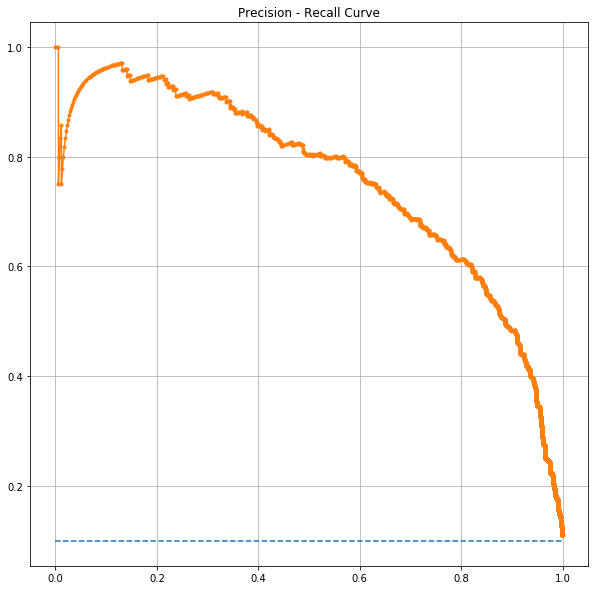

In [36]:
print('AUC: %.3f' % auc_score)
negative = len(y_test[y_test == 1])/ len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0,1], [negative, negative], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Precision - Recall Curve')
plt.grid()
plt.show()

### Lowering the Threshold

In [37]:
from numpy import argmax
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.228969, F-Score=0.702


### ROC CURVE

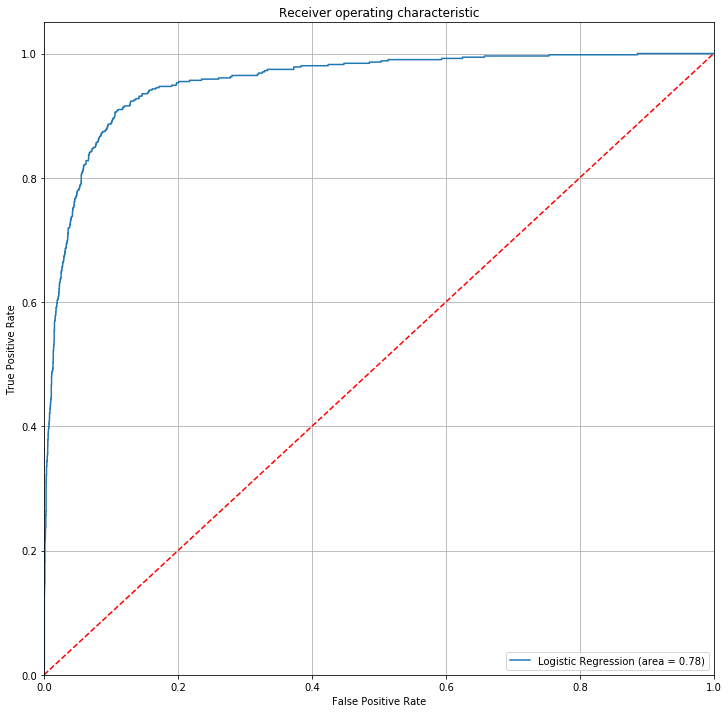

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_5.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_5.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.grid()
plt.show()

From the methods used, pre-trained word embeddings on 10-K's performed the best. Recall was maximized to above 90%.